# Mask R-CNN - Train on Brain Tumor Dataset


need a GPU. because the network backbone is a Resnet101, which would be too slow to train on a CPU

In [24]:
import warnings
warnings.filterwarnings(action='ignore')

In [1]:
#!git clone https://github.com/matterport/Mask_RCNN
#!git clone https://github.com/choco1ming/brain_tumor

import os 
os.chdir ('/content/Mask_RCNN')
!pip install -r 'requirements.txt'
!python3 setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 14.9 MB/s 
     |████████████████████████████████| 5.8 MB 49.0 MB/s 
     |████████████████████████████████| 1.4 MB 56.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 1.1

In [7]:
os.chdir('/content')

In [2]:
!pip install --upgrade h5py==2.10.0
!pip install q keras==2.2.5
!pip install tensorflow-gpu==1.15.0
!pip install -U scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.2.5-py2.py3-none-any.whl (336 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires keras<2.9,>=2.8.0rc0, but you have keras 2.2.5 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing install

In [9]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/") 

# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [10]:
# Dataset directory
DATASET_DIR = './brain_tumor/brain_tumor_data'

In [5]:
import skimage
import json
from PIL import Image, ImageDraw

In [12]:
print(skimage.__version__)

0.16.2


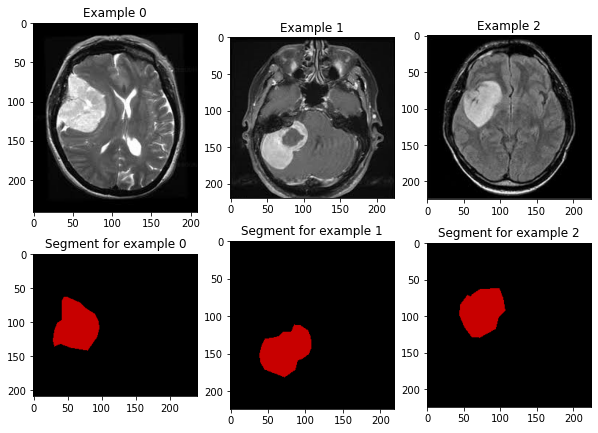

In [11]:
examples = [Image.open(DATASET_DIR + '/train/120.jpg'),Image.open(DATASET_DIR + '/train/116.jpg'),Image.open(DATASET_DIR+'/train/238.jpg')]
seg_examples = ['120.jpg9616','116.jpg10596','238.jpg9289']

# example images from train 
fig = plt.figure(figsize=(10,14))

for i in range(0, len(examples)):
    a = fig.add_subplot(1, 3, i+1)
    plot = plt.imshow(examples[i])
    a.set_title('Example '+str(i))

# ssegment examples from json annotations file
with open(DATASET_DIR+'/train/annotations.json') as json_file:
    jsonfile = json.load(json_file)
    for i in range(0,len(seg_examples)):
        # load regions and transform them into (x,y) coordinates
        coord = list(zip(jsonfile[seg_examples[i]]['regions'][0]['shape_attributes']['all_points_x'],jsonfile[seg_examples[i]]['regions'][0]['shape_attributes']['all_points_y'])) 
        image = Image.new("RGB", np.asarray(examples[i]).shape[0:2])
        draw = ImageDraw.Draw(image)
        draw.polygon((coord), fill=200)
        a = fig.add_subplot(2, 3, 3+i+1)
        plot = plt.imshow(image)
        a.set_title('Segment for example ' + str(i))

## Configurations

In [13]:
class BrainConfig(Config):
    """Configuration for training on the dataset.
    """
    # Give the configuration a recognizable name
    NAME = "brain"

    # GPU 몇개 돌릴 수 있는지 몰라서.. 1개 돌린다고 하고
    # 사진이 작은 사이즈니까 batch size를 8로 해도 되지 않을까? (images/GPU)
    # 라는 생각에 일단 아래와 같이 코드 해놓았음
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + crack

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # 이 부분은 이미 size 작게 해놓아서 일단은 킵
    # IMAGE_MIN_DIM = 128
    # IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # TRAIN_ROIS_PER_IMAGE : rois의 최대수
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    # VALIDATION_STEPS : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수
    VALIDATION_STEPS = 5

    # Skip detections with < 80% confidence
    # 80% 이상의 정확도에서만 Detection -> 85% 90% 뭘 해도 되지만 시간 상
    # train 많이 못할 것 같아서 80%로 설정하기는 했음
    DETECTION_MIN_CONFIDENCE = 0.8
    
config = BrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [14]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset
**class BrainDataset** :
* load_road()
* load_mask()
* image_reference()


In [15]:
class BrainDataset(utils.Dataset):
    """Load a subset of the road dataset.
    dataset_dir: Root directory of the dataset.
    subset: Subset to load: train or val
    """

    def load_data(self, dataset_dir, subset):
        """Load a subset of the road dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. 
        # 첫번째 인자 : NAME / 두번째 인자 : class의 번호 / 세번째 인자 : Labeling시 작성한 이름
        self.add_class("brain", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # 'annotations.json' : train, val 폴더 안의 image에 대한 json 파일
        annotations = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        # 이미지 갯수만큼 for loop를 돌며 regions의 좌표정보를 polygons에 저장하고 이미지에 좌표 정보를 넣음
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons(polylines) that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons(polylines) to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            ################ 아래의 a['filenmae'] 에 뭘 넣는지 모르겠움
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "brain",
                image_id=a['filename'],  # use file name as a unique image id # 그래서 어떻게 넣는건지 모르겠음
                path=image_path,
                width=width, height=height,
                polygons=polygons)  


    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a crack dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "brain":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons(polylines) to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # polyline 도 가능하게 if문 추가
            if (p['name'] == 'polygon') or (p['name'] == 'polyline'):
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1

            else:
                raise Exception('Unknown annotation type. Supported annotation types: Polygon, Polyline.')


        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)


    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "brain":
            return info["brain"]
        else:
            super(self.__class__).image_reference(self, image_id)


In [16]:
# Training dataset
dataset_train = BrainDataset()
dataset_train.load_data(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainDataset()
dataset_val.load_data(DATASET_DIR, 'val')
dataset_val.prepare()

# Test dataset
dataset_test = BrainDataset()
dataset_test.load_data(DATASET_DIR, 'test')
dataset_test.prepare()

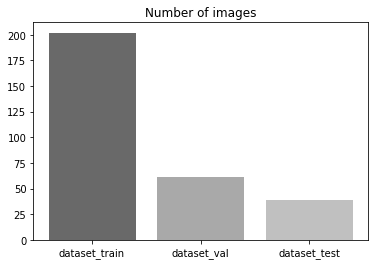

Class Count: 2
  0. BG                                                
  1. tumor                                             


In [74]:
# 확인
dataset_all = [dataset_train, dataset_val, dataset_test]
values ={}
for i,data in enumerate(dataset_all):
    values[i] = len(data.image_ids)

plt.title('Number of images')
plt.bar(range(len(values)), list(values.values()), align='center',color=['dimgrey','darkgray','silver'])
plt.xticks(range(len(values)), ['dataset_train', 'dataset_val', 'dataset_test'])
plt.show()
        
print("Class Count: {}".format(dataset_train.num_classes))
for i, info in enumerate(dataset_train.class_info):
    print("{:3}. {:50}".format(i, info['name']))

## Create Model

In [20]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir='logs')

In [22]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last 중에 쓰면 됨

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

In [25]:
# Learning rate : 학습을 통해 parameter update시 변화 값의 정도를 Control
# 위에서 Epoch당 training step은 100으로 설정
# layers : 'heads'는 COCO set에서 마지막 layer에 대해서만 parameter update를 진행
# ex) 3+의 경우 3 Layer 이후의 Parameter에 대해서 update 진행
print("Training network heads")
model.train(
    dataset_train, dataset_val,
    learning_rate=config.LEARNING_RATE,
    epochs=30,
    layers='heads')

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/brain20220728T1204/mask_rcnn_brain_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_

Epoch 1/30
100/100 [==============================] - 126s 1s/step - loss: 2.8789 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 1.4763 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.7222 - mrcnn_mask_loss: 0.4358 - val_loss: 2.1778 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 1.2597 - val_mrcnn_class_loss: 0.1361 - val_mrcnn_bbox_loss: 0.5282 - val_mrcnn_mask_loss: 0.2506



Epoch 2/30
100/100 [==============================] - 68s 679ms/step - loss: 1.9271 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 1.1411 - mrcnn_class_loss: 0.1026 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.2719 - val_loss: 1.8143 - val_rpn_class_loss: 0.0048 - val_rpn_bbox_loss: 1.2715 - val_mrcnn_class_loss: 0.0216 - val_mrcnn_bbox_loss: 0.3210 - val_mrcnn_mask_loss: 0.1954
Epoch 3/30
100/100 [==============================] - 67s 674ms/step - loss: 1.9148 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 1.1718 - mrcnn_class_loss: 0.0851 - mrcnn_bbox_loss: 0.3707 - mrcnn_mask_loss: 0.2805 - val_loss: 1.8482 - val_rpn_class_loss: 0.0072 - val_rpn_bbox_loss: 1.1453 - val_mrcnn_class_loss: 0.0770 - val_mrcnn_bbox_loss: 0.3645 - val_mrcnn_mask_loss: 0.2543
Epoch 4/30
100/100 [==============================] - 67s 674ms/step - loss: 1.5635 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.8876 - mrcnn_class_loss: 0.0900 - mrcnn_bbox_loss: 0.3158 - mrcnn_mask_loss: 0.2646 - val_loss: 1.3561 - val_rpn_c

## Detection

In [26]:
# 디스크 터지기 직전이라 멈췄음..! ㅠ
class InferenceConfig(BrainConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='logs')

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


Loading weights from  logs/brain20220728T1204/mask_rcnn_brain_0030.h5
Re-starting from epoch 30


In [27]:
# Test on a validation image
def predict_plot(dataset, img_id):
    image_id = img_id
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                            image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=1)
    r = results[0]

    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())

In [39]:
# original image
def display_image(dataset, img_id):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(img_id))
    plt.xticks([])
    plt.yticks([])
    plt.show()

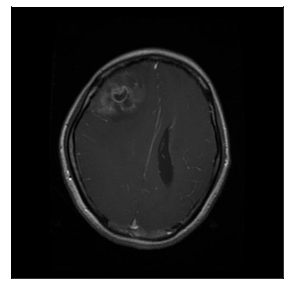

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  249.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  145.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.08847  max:    1.02591  float32


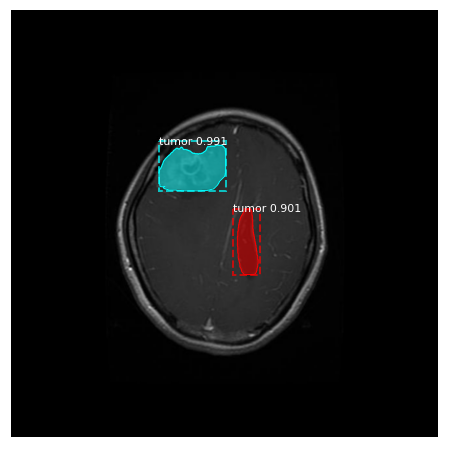

In [72]:
# show validation set detection(random)
img_id = random.choice(dataset_val.image_ids)
display_image(dataset_val, img_id)
predict_plot(dataset_val, img_id)

## Evaluation

In [30]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.725
